# LABORATORIO 5
## Jhamil Crespo Rejas
## Ingenieria en Ciencias de la Computacion

In [36]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

## Carga del dataset
* Definimos un `transform` para redimensionar las imagenes a 256x256 y convertirlas a tensores.
* Cargamos el dataset con `torchvision.datasets.ImageFolder` y le aplicamos el `transform` definido.
* Dividimos el dataset en un conjunto de entrenamiento y un conjunto de validación.
* Creamos `DataLoaders` para ambos conjuntos.
* Verificamos que las imagenes se cargaron correctamente.

In [37]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Transformaciones a aplicar a las imágenes
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionar las imágenes a 256x256 píxeles	
    transforms.ToTensor(),  # Convertir las imágenes en tensores
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalización a [-1, 1]
])

# Cargando el dataset completo desde la carpeta
dataset = torchvision.datasets.ImageFolder(root=r"C:\Users\Jhamil\Desktop\Dataset10mil", transform=transform)

# Dividiendo el dataset en 80% para entrenamiento y 20% para prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = random_split(dataset, [train_size, test_size])

# Creando DataLoaders para entrenamiento y prueba
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

# Clases del dataset
classes = ('AmorSeco', 'Boldo', 'Charanguillo', 'Ortiga', 'Peregil')

# Tamaño de los datasets
print(f'Tamaño del set de entrenamiento: {len(trainset)}')
print(f'Tamaño del set de prueba: {len(testset)}')


Tamaño del set de entrenamiento: 8038
Tamaño del set de prueba: 2010


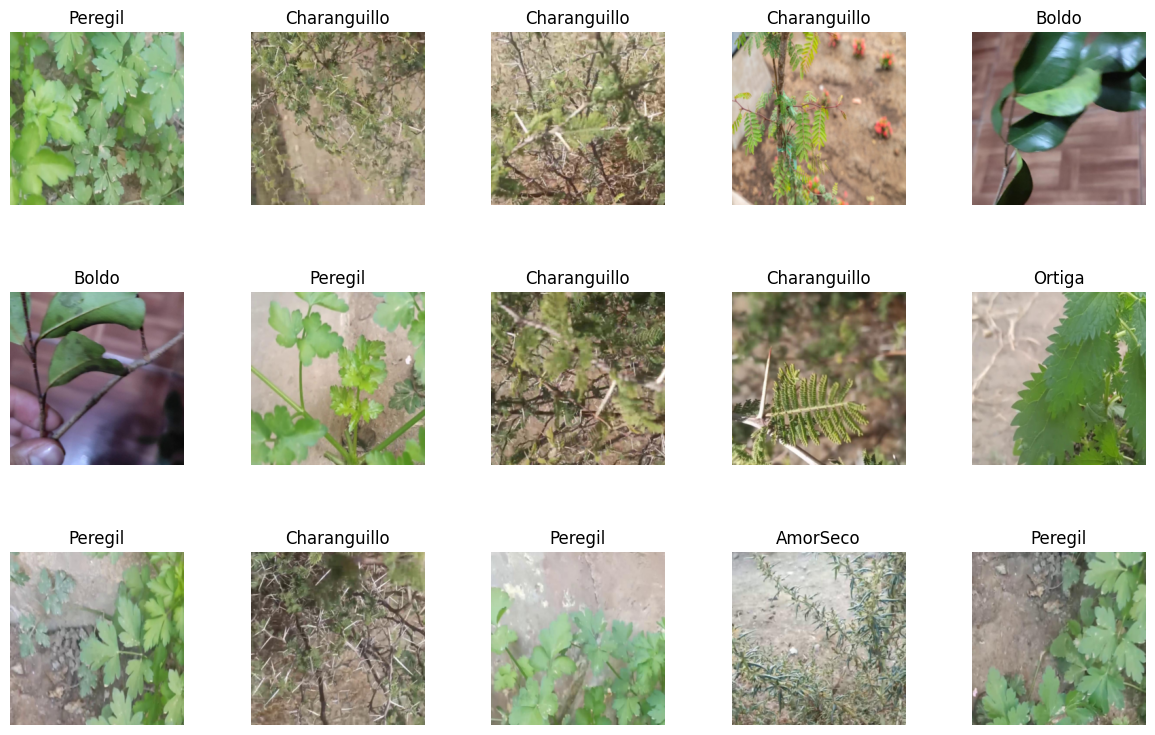

In [38]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Función para deshacer la transformación y convertir de tensor a imagen
def imshow(img):
    # Convirtiendo de tensor a numpy y cambiar el orden de los canales de (C, H, W) a (H, W, C)
    img = img.numpy().transpose((1, 2, 0))
    # Normalizando los valores de la imagen al rango [0, 1]
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# Visualización de imágenes
r, c = 3, 5
plt.figure(figsize=(c * 3, r * 3))
for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset) - 1)
        img, label = trainset[ix]
        imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


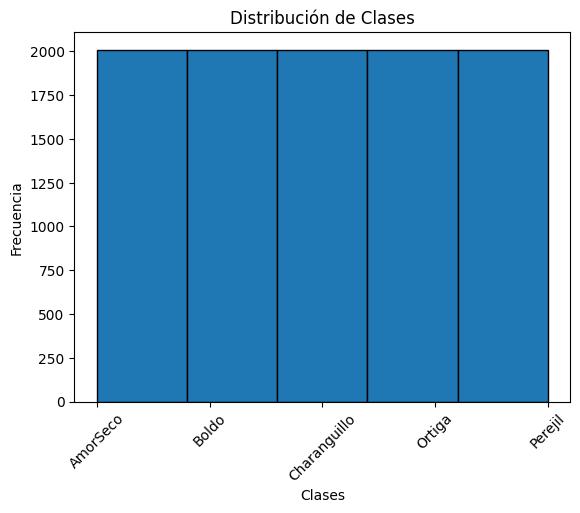

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Obteniendo las etiquetas correspondientes a los índices de entrenamiento
train_labels = [label for _, label in dataset.samples]
train_labels = np.array(train_labels)

# Nombres de las clases
class_names = list(dataset.class_to_idx.keys())

# Distribución de clases - Mostrar histograma de las primeras 30,000 imágenes (o menos si hay menos en el set)
plt.hist(train_labels[:30000], bins=len(class_names), edgecolor='black')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Distribución de Clases')
plt.show()


## Generador
* Definimos una clase personalizada para el modelo generador en donde iremos modificando 2 aspectos a mientras va pasando por las capas:
* **Tamaño de características** (o canales) refleja la cantidad de información sobre patrones que la red está extrayendo.
* **Resolución** es la cantidad de detalle en la imagen generada. A medida que la imagen pasa por capas transpuestas, la resolución espacial aumenta.
* La clase recibe en su constructor la dimension del vector de ruido `latem_dim` que por defecto es 100. Tambien puede recibir la cantidad de canales de la imagen de salida `channels_img` que por defecto es 3. Y un parametro base para el tamaño de las capas `features_g` que por defecto es 64.
* El modelo tiene 7 (mas la capa de entrada y salida) capas convolucionales transpuestas con normalización por lotes y activación ReLU.
### 1. Capa convolucional transpuesta
* Recibe un vector de ruido de tamaño `latem_dim` y lo convierte en un tensor de características con tamaño feature_g * 16 = 64 * 16 = 1024 y una resolución de 4x4. Esto se logra gracias al kernel de 4x4 con stride de 1 y padding de 0 que llega a 4x4 a partir del vector de entrada que es 1x1.
* Luego se aplican normalización por lotes y activación ReLU.
### 2. Capa convolucionale transpuesta
* Recibe un tensor de características de tamaño 1024 y lo convierte en un tensor de características con tamaño 512 y una resolución de 8x8. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 8x8 a partir del tensor de entrada que es 4x4.
* Luego se aplican normalización por lotes y activación ReLU.
### 3. Capa convolucionale transpuesta
* Recibe un tensor de características de tamaño 512 y lo convierte en un tensor de características con tamaño 256 y una resolución de 16x16. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 16x16 a partir del tensor de entrada que es 8x8.
* Luego se aplican normalización por lotes y activación ReLU.
### 4. Capa convolucionale transpuesta
* Recibe un tensor de características de tamaño 256 y lo convierte en un tensor de características con tamaño 128 y una resolución de 32x32. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 32x32 a partir del tensor de entrada que es 16x16.
* Luego se aplican normalización por lotes y activación ReLU.
### 5. Capa convolucionale transpuesta
* Recibe un tensor de características de tamaño 128 y lo convierte en un tensor de características con tamaño de 64 y una resolución de 64x64. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 64x64 a partir del tensor de entrada que es 32x32.
* Luego se aplican normalización por lotes y activación ReLU.
### 6. Capa convolucionale transpuesta
* Recibe un tensor de características de tamaño 64 y lo convierte en un tensor de características con tamaño de 32 y una resolución de 128x128. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 128x128 a partir del tensor de entrada que es 64x64.
* Luego se aplican normalización por lotes y activación ReLU.
### Capa de salida
* Recibe un tensor de características de tamaño 32 y lo convierte en un tensor de características con tamaño de `channels_img` que en este caso es 3 y una resolución de 256x256. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 256x256 a partir del tensor de entrada que es 128x128.
* Se utiliza `nn.Tanh()` en lugar de ReLU aquí, ya que la función Tanh asegura que los valores de salida estén en el rango [-1, 1], que es el formato estándar para la normalización de imágenes generadas.
### Forward
Se pasa el vector de entrada (el vector de ruido z) a través de la red. El vector z se pasa a través de todas las capas secuenciales definidas en self.model y retorna una imagen generada.

In [40]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3, feature_g=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Entrada: vector de ruido (100), salida: 1024x4x4
            nn.ConvTranspose2d(latent_dim, feature_g * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_g * 16),
            nn.ReLU(True),

            # Capa intermedia: 1024x4x4 -> 512x8x8
            nn.ConvTranspose2d(feature_g * 16, feature_g * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),

            # Capa intermedia: 512x8x8 -> 256x16x16
            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),

            # Capa intermedia: 256x16x16 -> 128x32x32
            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),

            # Capa intermedia: 128x32x32 -> 64x64x64
            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),

            # Capa intermedia: 64x64x64 -> 32x128x128
            nn.ConvTranspose2d(feature_g, feature_g // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_g // 2),
            nn.ReLU(True),

            # Salida: 32x128x128 -> 3x256x256
            nn.ConvTranspose2d(feature_g // 2, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()  # Salida en el rango [-1, 1]
        )

    def forward(self, z):
        return self.model(z)


## Discriminador
* Definimos una clase personalizada para el modelo discriminador en donde iremos modificando 2 aspectos a mientras va pasando por las capas:
* **Tamaño de características** (o canales) refleja la cantidad de información sobre patrones que la red está extrayendo.
* **Resolución** es la cantidad de detalle en la imagen generada. A medida que la imagen pasa por capas convolucionales, la resolución espacial disminuye.
* La clase recibe en su constructor la cantidad de canales de la imagen de entrada `img_channels` que por defecto es 3. Y un parametro base para el tamaño de las capas `features_d` que por defecto es 64.
* El modelo tiene 5 capas convolucionales (mas la capa de entrada) con normalización por lotes y activación Leaky ReLU.
### 1. Capa convolucional
* Recibe una imagen de tamaño 3x256x256 y la convierte en un tensor de características con tamaño 64 y una resolución de 128x128. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 128x128 a partir de la imagen de entrada que es 256x256.
* Luego se aplica activación Leaky ReLU.
### 2. Capa convolucional
* Recibe un tensor de características de tamaño 64 y lo convierte en un tensor de características con tamaño 128 y una resolución de 64x64. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 64x64 a partir del tensor de entrada que es 128x128.
* Luego se aplica normalización por lotes y activación Leaky ReLU.
### 3. Capa convolucional
* Recibe un tensor de características de tamaño 128 y lo convierte en un tensor de características con tamaño 256 y una resolución de 32x32. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 32x32 a partir del tensor de entrada que es 64x64.
* Luego se aplica normalización por lotes y activación Leaky ReLU.
### 4. Capa convolucional
* Recibe un tensor de características de tamaño 256 y lo convierte en un tensor de características con tamaño 512 y una resolución de 16x16. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 16x16 a partir del tensor de entrada que es 32x32.
* Luego se aplica normalización por lotes y activación Leaky ReLU.
### 5. Capa convolucional
* Recibe un tensor de características de tamaño 512 y lo convierte en un tensor de características con tamaño 1024 y una resolución de 8x8. Esto se logra gracias al kernel de 4x4 con stride de 2 y padding de 1 que llega a 8x8 a partir del tensor de entrada que es 16x16.
* Luego se aplica normalización por lotes y activación Leaky ReLU.
### Reduccion Final de la Imagen
* Se aplica pooling para reducir la resolución de la imagen a 1x1. Usando `AdaptiveAvgPool2d(1, 1)` reduce la imagen a un solo valor por canal (1x1) con un promedio adaptativo.
### Capa de salida
* `Flatten()` aplana el tensor, de modo que se convierte en una matriz unidimensional de tamaño `[batch_size, 1024]`.
* `Linear(1024, 1)` es una capa totalmente conectada que toma las 1024 características y produce un solo valor de salida.
* `Sigmoid()` se usa para convertir ese valor a una probabilidad entre 0 y 1, lo que te indica si la imagen es real o falsa (clasificación binaria).
### Forward
Se pasa la imagen de entrada a través de la red. La imagen se pasa a través de todas las capas secuenciales definidas en self.model y retorna una probabilidad de que la imagen sea real.

In [41]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Entrada: 3x256x256 -> 64x128x128
            nn.Conv2d(img_channels, feature_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64x128x128 -> 128x64x64
            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # 128x64x64 -> 256x32x32
            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # 256x32x32 -> 512x16x16
            nn.Conv2d(feature_d * 4, feature_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # 512x16x16 -> 1024x8x8
            nn.Conv2d(feature_d * 8, feature_d * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_d * 16),
            nn.LeakyReLU(0.2, inplace=True),

            # 1024x8x8 -> 1x1x1 (usando AdaptiveAvgPool2d para reducir el tamaño)
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),  # Aplana el tensor a [batch_size, 1]
            nn.Linear(feature_d * 16, 1),  # Capa lineal para obtener un solo valor por imagen
            nn.Sigmoid()  # Clasificación binaria
        )

    def forward(self, img):
        return self.model(img)


## Inicializacion de Pesos
* La función recibe como argumento un módulo (m), que será una capa de la red (como una capa convolucional o de normalización).
* `m.__class__.__name__` obtiene el nombre de la clase del módulo m. Esto es útil para identificar el tipo de capa al que pertenece m, ya que las estrategias de inicialización varían según el tipo de capa.
### Capas Convolucionales y Transpuestas
* Si el nombre de la clase contiene "Conv" (es decir, si es una capa convolucional como Conv2d o ConvTranspose2d), se utiliza una inicialización normal para los pesos.
    * `nn.init.normal_(m.weight.data, 0.0, 0.02)` inicializa los pesos con una distribución normal con media 0 y desviación estándar 0.02.
* Si la capa convolucional tiene un sesgo (bias), entonces el sesgo se inicializa a 0.
    * `nn.init.constant_(m.bias.data, 0)` establece todos los valores del sesgo a 0 de forma constante.
* Esta inicialización es típica en arquitecturas como GANs, donde se necesita un control cuidadoso de los pesos iniciales para evitar que la red caiga en puntos inestables durante el entrenamiento.
### Capas BatchNorm
* Si el nombre de la clase contiene "BatchNorm" (como BatchNorm2d), se inicializan los pesos y sesgos de la capa de normalización por lotes.
    * `nn.init.normal_(m.weight.data, 1.0, 0.02)` inicializa los pesos con una distribución normal con media 1 y desviación estándar 0.02. Esto es importante porque las capas de BatchNorm utilizan estos pesos para ajustar la normalización durante el entrenamiento.
    * `nn.init.constant_(m.bias.data, 0)` inicializa el sesgo a 0.
* Las capas de BatchNorm normalizan los activaciones de cada lote de datos y luego aplican estos pesos y sesgos para reescalar las activaciones, lo cual ayuda a mantener la estabilidad durante el entrenamiento.
### capas Lineales
* Si el nombre de la clase contiene "Linear" (como Linear), también se inicializan los pesos y sesgos de manera similar a las capas convolucionales.
    * Los pesos se inicializan con una distribución normal con media 0 y desviación estándar 0.02.
    * Los sesgos se inicializan a 0.

In [42]:
# Función para inicializar pesos
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:  # Para capas convolucionales
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:  # Para capas de BatchNorm
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:  # Para capas lineales (opcional)
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


* latent_dim: El tamaño del vector de entrada de ruido para el generador. Este vector es la entrada aleatoria que el generador usará para crear imágenes.
* lr: La tasa de aprendizaje (learning rate) utilizada por los optimizadores. Determina qué tan grandes son los pasos de actualización de los parámetros durante el entrenamiento.
* beta1: Un parámetro específico del optimizador Adam, que controla el decaimiento de las primeras estimaciones de momentos de las gradientes. Ayuda a mejorar la estabilidad en modelos generativos adversarios (GANs).
* Generator y Discriminator: Los dos modelos, el Generador (netG) y el Discriminador (netD), se inicializan con los parámetros respectivos. El Generador toma el tamaño del vector de ruido (latent_dim=256) como entrada.
* .to(device): Mueve los modelos a la GPU si está disponible, o a la CPU en su defecto.
* weights_init: Esta función se aplica a los modelos para inicializar los pesos de cada capa de acuerdo con el tipo de capa (convolucional, batch normalization, lineal, etc.). Esto es importante para que el entrenamiento comience con pesos que faciliten la convergencia.

In [43]:
import torch.optim as optim
import psutil  # Para monitorear el uso de RAM
import GPUtil  # Para monitorear el uso de GPU

import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

# Parámetros
latent_dim = 256
lr = 0.0002
#beta1 = 0.5

# Modelos
netG = Generator(latent_dim=latent_dim).to(device)
netG.apply(weights_init)  # Inicializar pesos
netD = Discriminator().to(device)
netD.apply(weights_init)  # Inicializar pesos

# Optimizadores
optimizerG = optim.Adam(netG.parameters(), lr=lr)
optimizerD = optim.Adam(netD.parameters(), lr=lr)
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Función de pérdida
criterion = nn.BCELoss()


In [44]:
import torch
import torch.nn as nn
import os
import GPUtil
import psutil

def train_gan(generator, discriminator, dataloader, latent_dim, optimizerG, optimizerD, criterion, device, num_epochs=50, checkpoint_dir=r"C:\Users\Jhamil\Desktop\IA2\checkpoints"):
    """
    Función para entrenar una GAN y guardar checkpoints del generador y discriminador.
    
    Parámetros:
        generator (nn.Module): Modelo del generador.
        discriminator (nn.Module): Modelo del discriminador.
        dataloader (DataLoader): Cargador de datos para el conjunto de imágenes reales.
        latent_dim (int): Dimensión del vector de ruido para el generador.
        optimizerG (Optimizer): Optimizador para el generador.
        optimizerD (Optimizer): Optimizador para el discriminador.
        criterion (Loss): Función de pérdida.
        device (torch.device): GPU o CPU.
        num_epochs (int): Número de épocas de entrenamiento.
        checkpoint_dir (str): Directorio donde guardar los checkpoints.
    """
    
    # Etiquetas reales (1) y falsas (0)
    real_label = 1.0
    fake_label = 0.0
    
    # Listas para guardar pérdidas y métricas de cada época
    G_losses = []
    D_losses = []
    gpu_usage = []
    ram_usage = []
    max_gpu_usage = []
    gpu_percent = []

    # Bucle de entrenamiento
    for epoch in range(num_epochs):
        # Inicializar métricas para la época
        epoch_G_losses = []
        epoch_D_losses = []
        epoch_gpu_usage = []
        epoch_ram_usage = []
        epoch_max_gpu_usage = []
        epoch_gpu_percent = []
        
        for i, (real_images, _) in enumerate(dataloader):
            
            # --- Actualización del discriminador ---  
            discriminator.zero_grad() # Inicializar los gradientes del discriminador
            real_images = real_images.to(device) # Mover imágenes al dispositivo
            batch_size = real_images.size(0) # Tamaño del lote
            
            # Etiquetas reales
            labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device) # Llenar con 1s
            output_real = discriminator(real_images).view(-1)  # Aplanar salida
            loss_real = criterion(output_real, labels)
            loss_real.backward()
            
            # Entrenar con imágenes generadas (falsas)
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_images = generator(noise)
            
            # Etiquetas falsas
            labels.fill_(fake_label)
            output_fake = discriminator(fake_images.detach()).view(-1)  # Aplanar salida
            loss_fake = criterion(output_fake, labels)
            loss_fake.backward()
            
            # Actualizar discriminador
            optimizerD.step()
            
            # --- Actualización del generador ---  
            generator.zero_grad()
            labels.fill_(real_label)  # Queremos que el generador haga que el discriminador piense que las imágenes falsas son reales
            output_fake_for_G = discriminator(fake_images).view(-1)  # Aplanar salida
            loss_G = criterion(output_fake_for_G, labels)
            loss_G.backward()
            
            # Actualizar generador
            optimizerG.step()
            
            # Acumulación de las pérdidas
            epoch_G_losses.append(loss_G.item())
            epoch_D_losses.append((loss_real.item() + loss_fake.item()) / 2)

            # Monitoreo de uso de GPU (si está disponible) y RAM
            if torch.cuda.is_available():
                epoch_gpu_usage.append(torch.cuda.memory_allocated(device) / (1024 ** 2))  # En MB
                epoch_max_gpu_usage.append(torch.cuda.max_memory_allocated(device) / (1024 ** 2))  # En MB
                
                # Uso porcentual de la GPU
                gpus = GPUtil.getGPUs()
                epoch_gpu_percent.append(gpus[0].load * 100)  # Porcentaje de uso de GPU
            else:
                epoch_gpu_usage.append(0)  # Si no hay GPU, se guarda 0
                epoch_max_gpu_usage.append(0)
                epoch_gpu_percent.append(0)  # Si no hay GPU, se guarda 0
                
            epoch_ram_usage.append(psutil.virtual_memory().used / (1024 ** 2))  # RAM usada en MB
            
            # Mostrar progreso
            if i % 100 == 0:
                # Formatear las pérdidas como cadena si no están disponibles
                loss_D_str = f'{D_losses[-1]:.4f}' if D_losses else "N/A"
                loss_G_str = f'{loss_G.item():.4f}' if loss_G else "N/A"

                print(f'Epoch [{epoch+1}/{num_epochs}], Paso [{i}/{len(dataloader)}], '
                      f'Pérdida D: {loss_D_str}, Pérdida G: {loss_G_str}, '
                      f'GPU: {epoch_gpu_usage[-1] if epoch_gpu_usage else 0:.2f} MB (Máx: {epoch_max_gpu_usage[-1] if epoch_max_gpu_usage else 0:.2f} MB), '
                      f'Porcentaje de GPU: {epoch_gpu_percent[-1] if epoch_gpu_percent else 0:.2f}%, RAM: {epoch_ram_usage[-1] if epoch_ram_usage else 0:.2f} MB')
                
        # Guardar métricas al final de cada época
        G_losses.append(sum(epoch_G_losses) / len(epoch_G_losses))
        D_losses.append(sum(epoch_D_losses) / len(epoch_D_losses))
        gpu_usage.append(sum(epoch_gpu_usage) / len(epoch_gpu_usage))
        ram_usage.append(sum(epoch_ram_usage) / len(epoch_ram_usage))
        max_gpu_usage.append(sum(epoch_max_gpu_usage) / len(epoch_max_gpu_usage))
        gpu_percent.append(sum(epoch_gpu_percent) / len(epoch_gpu_percent))
        
        # Guardar checkpoints al final de cada epoch
        checkpoint_path = os.path.join(checkpoint_dir, f'gan256x256_epoch_{epoch+1}.pth')
        torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
        }, checkpoint_path)
        print(f'Checkpoint guardado para la epoch {epoch+1}.')
    
    # Guardar el modelo final al final del entrenamiento
    final_model_path = os.path.join(checkpoint_dir, 'gan256x256_final.pth')
    torch.save({
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
    }, final_model_path)
    print(f'Modelos finales guardados en {final_model_path}')

    return G_losses, D_losses, gpu_usage, ram_usage, max_gpu_usage, gpu_percent


In [45]:
import matplotlib.pyplot as plt

def plot_metrics(G_losses, D_losses, gpu_usage, ram_usage, max_gpu_usage, gpu_percent):
    """
    Función para graficar las métricas del entrenamiento: pérdidas del generador, pérdidas del discriminador,
    uso de GPU, uso máximo de GPU y uso porcentual de la GPU.
    
    Parámetros:
        G_losses (list): Lista de pérdidas del generador.
        D_losses (list): Lista de pérdidas del discriminador.
        gpu_usage (list): Lista de uso de GPU en MB.
        ram_usage (list): Lista de uso de RAM en MB.
        max_gpu_usage (list): Lista de uso máximo de GPU en MB.
        gpu_percent (list): Lista de uso porcentual de GPU.
    """
    plt.figure(figsize=(20, 15))

    # Gráfico de pérdidas del generador
    plt.subplot(3, 2, 1)
    plt.plot(G_losses, label="Pérdida del Generador", color='blue')
    plt.xlabel("Iteraciones")
    plt.ylabel("Pérdida")
    plt.title("Pérdida del Generador")
    plt.legend()

    # Gráfico de pérdidas del discriminador
    plt.subplot(3, 2, 2)
    plt.plot(D_losses, label="Pérdida del Discriminador", color='red')
    plt.xlabel("Iteraciones")
    plt.ylabel("Pérdida")
    plt.title("Pérdida del Discriminador")
    plt.legend()
    
    # Gráfico de uso de GPU
    plt.subplot(3, 2, 3)
    plt.plot(gpu_usage, label="Uso de GPU (MB)", color='green')
    plt.xlabel("Iteraciones")
    plt.ylabel("Uso de GPU (MB)")
    plt.title("Uso de GPU durante el Entrenamiento")
    plt.legend()
    
    # Gráfico de uso máximo de GPU
    plt.subplot(3, 2, 4)
    plt.plot(max_gpu_usage, label="Uso Máximo de GPU (MB)", color='purple')
    plt.xlabel("Iteraciones")
    plt.ylabel("Uso Máximo de GPU (MB)")
    plt.title("Uso Máximo de GPU durante el Entrenamiento")
    plt.legend()

    # Gráfico de porcentaje de GPU
    plt.subplot(3, 2, 5)
    plt.plot(gpu_percent, label="Porcentaje de Uso de GPU (%)", color='orange')
    plt.xlabel("Iteraciones")
    plt.ylabel("Porcentaje (%)")
    plt.title("Uso Porcentual de GPU durante el Entrenamiento")
    plt.legend()

    # Gráfico de uso de RAM
    plt.subplot(3, 2, 6)
    plt.plot(ram_usage, label="Uso de RAM (MB)", color='cyan')
    plt.xlabel("Iteraciones")
    plt.ylabel("Uso de RAM (MB)")
    plt.title("Uso de RAM durante el Entrenamiento")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [46]:
# Asumiendo que has entrenado la GAN y obtenido las métricas
G_losses, D_losses, gpu_usage, ram_usage, max_gpu_usage, gpu_percent = train_gan(netG, netD, trainloader, latent_dim, optimizerG, optimizerD, criterion, device, num_epochs=200)

# Graficar las métricas
plot_metrics(G_losses, D_losses, gpu_usage, ram_usage, max_gpu_usage, gpu_percent)

Epoch [1/200], Paso [0/503], Pérdida D: N/A, Pérdida G: 0.7442, GPU: 1302.55 MB (Máx: 1517.13 MB), Porcentaje de GPU: 89.00%, RAM: 10500.84 MB
Epoch [1/200], Paso [100/503], Pérdida D: N/A, Pérdida G: 1.1973, GPU: 1302.55 MB (Máx: 1693.07 MB), Porcentaje de GPU: 80.00%, RAM: 10343.29 MB
Epoch [1/200], Paso [200/503], Pérdida D: N/A, Pérdida G: 0.9955, GPU: 1302.55 MB (Máx: 1693.07 MB), Porcentaje de GPU: 23.00%, RAM: 10354.20 MB
Epoch [1/200], Paso [300/503], Pérdida D: N/A, Pérdida G: 1.0465, GPU: 1302.55 MB (Máx: 1693.07 MB), Porcentaje de GPU: 19.00%, RAM: 10242.89 MB
Epoch [1/200], Paso [400/503], Pérdida D: N/A, Pérdida G: 0.9225, GPU: 1302.55 MB (Máx: 1693.07 MB), Porcentaje de GPU: 41.00%, RAM: 9943.98 MB
Epoch [1/200], Paso [500/503], Pérdida D: N/A, Pérdida G: 1.2347, GPU: 1302.55 MB (Máx: 1693.07 MB), Porcentaje de GPU: 35.00%, RAM: 9936.74 MB
Checkpoint guardado para la epoch 1.
Epoch [2/200], Paso [0/503], Pérdida D: 0.5644, Pérdida G: 1.6395, GPU: 1302.55 MB (Máx: 1694.08 

IndexError: list index out of range

In [47]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure  # Para ecualización de histograma

def generate_and_show_images(generator, latent_dim, num_images=10, device='cuda'):
    """
    Genera y muestra imágenes utilizando el generador entrenado.
    
    Parámetros:
        generator (nn.Module): Modelo del generador entrenado.
        latent_dim (int): Dimensión del vector de ruido para el generador.
        num_images (int): Número de imágenes a generar.
        device (torch.device): Dispositivo (GPU/CPU) en el que se ejecuta el modelo.
    """
    # Poner el generador en modo evaluación
    generator.eval()
    
    # Generar un batch de imágenes
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
    fake_images = generator(noise).detach().cpu()  # Generar imágenes y moverlas a CPU para visualizar
    
    # Convertir las imágenes generadas al rango [0, 1] (las imágenes están en [-1, 1] después de Tanh)
    fake_images = (fake_images + 1) / 2
    
    # Verificar valores mínimo y máximo
    print(f"Valores mínimos: {fake_images.min().item()}, máximos: {fake_images.max().item()}")

    # Ajustar el contraste aplicando corrección gamma
    gamma = 1.5  # Ajustar este valor según sea necesario
    fake_images = torch.pow(fake_images, gamma)

    # Escalar al rango completo [0, 1]
    fake_images = (fake_images - fake_images.min()) / (fake_images.max() - fake_images.min())
    
    # Ecualización del histograma
    fake_images_np = fake_images.permute(0, 2, 3, 1).numpy()  # Cambiar a HWC para skimage
    fake_images_eq = np.array([exposure.equalize_hist(img) for img in fake_images_np])

    # Crear una cuadrícula para mostrar las imágenes
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    
    for i in range(num_images):
        axes[i].imshow(fake_images_eq[i], vmin=0, vmax=1)
        axes[i].axis('off')  # Ocultar los ejes
    
    plt.tight_layout()  # Ajustar los espacios entre imágenes
    plt.show()

# Ejemplo de uso:
# generate_and_show_images(generator=netG, latent_dim=100, num_images=10, device=device)


In [52]:
# Cargar el mejor generador guardado
generator = Generator(latent_dim).to(device)
# Cargar el checkpoint
checkpoint = torch.load(r"C:\Users\Jhamil\Desktop\IA2\checkpoints\gan256x256_epoch_93.pth")

discriminator = Discriminator().to(device)

# Cargar el estado del generador, discriminador y optimizadores
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

print("Checkpoint cargado correctamente.")


C:\Users\Jhamil\AppData\Local\Temp\ipykernel_19052\974981431.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\Jhamil\Desktop\IA2\checkp

Checkpoint cargado correctamente.


Valores mínimos: 0.4475431740283966, máximos: 0.9939425587654114


c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


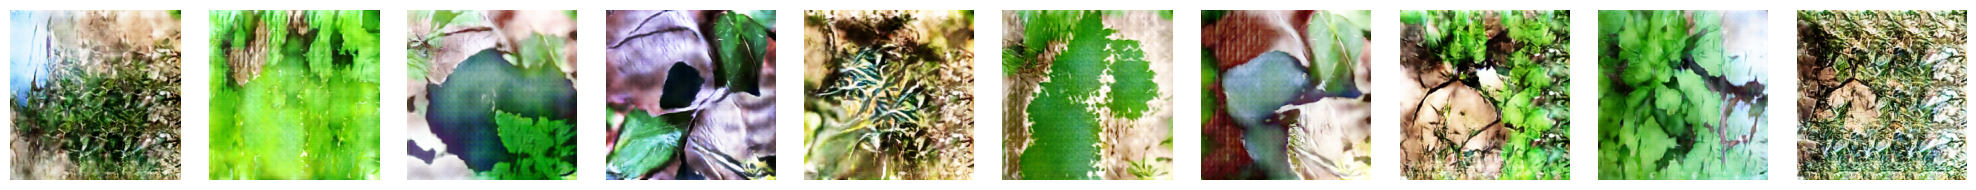

In [48]:
generate_and_show_images(generator=netG, latent_dim=256, num_images=10, device=device)

Valores mínimos: 0.28799307346343994, máximos: 0.9979874491691589


c:\Users\Jhamil\Desktop\IA2\env\lib\site-packages\skimage\_shared\utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


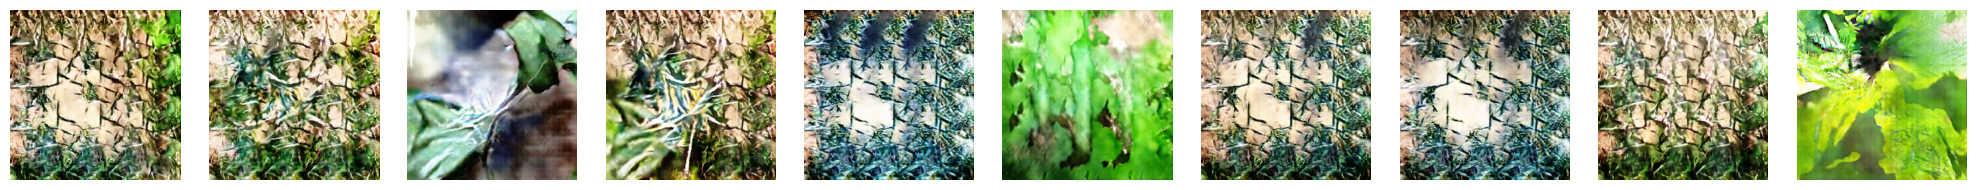

In [53]:
generate_and_show_images(generator=generator, latent_dim=256, num_images=10, device=device)